<a href="https://colab.research.google.com/github/osienka/NLP_Final_Project/blob/main/The_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final NLP assgnment

Zofia Hendrysiak

In this project I created a model to recognize images presenting American Sign Language signs. The dataset I used comes from Kaggle. My goal was to train the model so it can differenciate every character from ASL alphabet.

All conclusions I wrote are for the data that I managed to get. Please have it in mind while reading. The seed is set, so the outcomes shouldn't be different if someone wants to run the code.

The data is available here:

https://drive.google.com/file/d/103yqrOV0OgaaByp2rx-CICwz23HjZXuJ/view?usp=sharing

In [1]:
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import statistics
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomRotation
import gdown

# Setting the seed so the results should be similar
seed = 128
rng = np.random.RandomState(seed)

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Here you should probably change the path to zipped dataset inorder to unzip it
!unzip -q /content/drive/MyDrive/NLP_Final_assignment/archive.zip

The 0 sign
(400, 400)


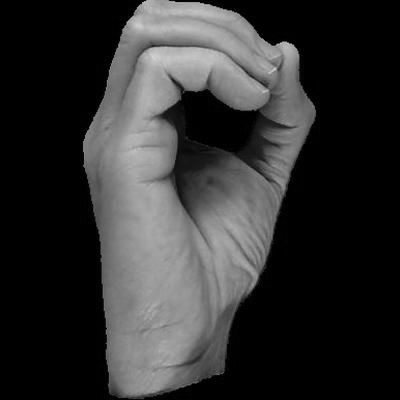

In [4]:
# Checking files 
files = os.listdir('/content/archive(3)/asl_dataset/')
# Path to one of the images
path = os.path.join('/content/archive(3)/asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg')
img = load_img(path, color_mode='grayscale')

# Showing one of signs presenting 0
print('The 0 sign')
img_arr = np.asarray(img)
print(img_arr.shape)
inputShape = img_arr.shape
img

Please make sure that the path to the *folder* is correct. If not you can simply change it to the path were your unzipped data is stored.

In [5]:
# Loading the data - you can change the folder to path where you store the data
folder = '/content/archive(3)/asl_dataset'
def load_data(folder, height, width, color):    
    '''
    load images from 'folder' which contains subfolders as labels
    returns vectors X (inputs) and Y (labels) ready for training/testing
    '''
    
    list_labels = [f for f in os.listdir(folder)]

    X = [] 
    Y = [] 

    for label in list_labels:
        current_dir = os.path.join(folder, label)
        for img_file in os.listdir(current_dir):
            if not img_file.startswith('.'):
                img = load_img(os.path.join(current_dir, img_file), 
                               color_mode=color, target_size=(height, width))
                X.append(np.array(img)/255)
                if len(label) > 1:
                  Y.append(26)
                elif ord(label) >= 48 and ord(label) <= 57:
                  Y.append(label)
                else:
                  Y.append(ord(label) - ord('a') + 10)

    X = np.array(X).reshape(-1, height, width, 1)          
    Y = to_categorical(Y, 36)
    return X, Y                        


# Size of the image and the color
height = 100
width = 100
color = 'grayscale'

# Load and transform images
# If you use different way to grade the notebook please be sure to change the path
X, Y = load_data(folder, height, width, color)

I checked distribution of data in each set. I wanted to know if the data is splitted in even way. The distribution is shown on the plots below.

I came to a conclusion that the dataset is splitted in right way.

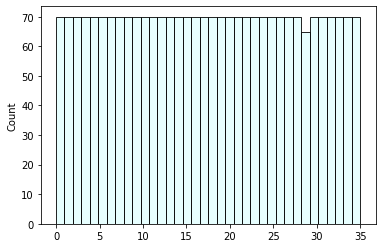

In [6]:
import seaborn as sns
sns.histplot([i for i in range(36) for j in range(len(Y)) if Y[j,i] == 1],
             bins=36, color = "lightcyan")

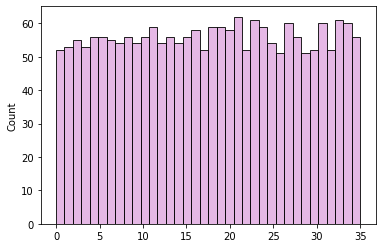

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= 354)

sns.histplot([i for i in range(36) for j in range(len(Y_train)) if Y_train[j,i] == 1], 
             bins=36, color = "plum")

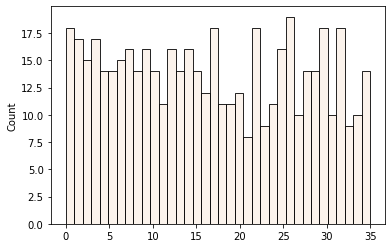

In [8]:
sns.histplot([i for i in range(36) for j in range(len(Y_test)) if Y_test[j,i] == 1], 
             bins=36, color = "linen")

**Model**

Here is the part in which model is created. It has two convolutional, maxpooling and dropout layers. It also has a layer that is rotating the image a bit. At the end the model flattens the data and has one more - this time dense - layer.

In [9]:
# Cnn model

model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(height, width, 1)))
model.add(MaxPooling2D(pool_size = (3,3))) 
model.add(Dropout(0.25))
model.add(RandomRotation(factor=(-0.05,0.05)))

model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size = (3,3))) 
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(len(Y[0]), activation='softmax'))

model.summary()


model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Saving training 
mymodel = model.fit(X_train, Y_train, epochs = 15, validation_split = 0.2)
model.save("model.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 32)       0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0

Test loss: 0.15330570936203003


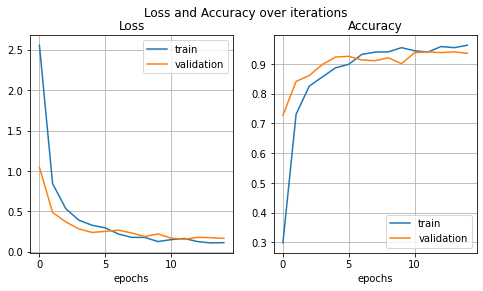

In [10]:
# PLOT LOSS AND ACCURACY HISTORY
def plot_loss_accuracy(loss, val_loss, acc, val_acc):
    ''' Plots loss value and acccuracy score for both training and validation
    sets in every epoch
    '''
    fig = plt.figure(figsize=(8, 4))
    fig.suptitle('Loss and Accuracy over iterations')
    
    # add_subplot(nrows, ncolumns, index)
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss)
    ax.plot(val_loss)
    ax.grid(True)
    ax.set(xlabel='epochs', title='Loss')
    ax.legend(['train', 'validation'], loc='upper right')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(acc)
    ax.plot(val_acc)
    ax.grid(True)
    ax.set(xlabel='epochs', title='Accuracy')
    ax.legend(['train', 'validation'], loc='lower right')

plot_loss_accuracy(mymodel.history['loss'], 
                   mymodel.history['val_loss'], 
                   mymodel.history['accuracy'], 
                   mymodel.history['val_accuracy'])

# testing the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)

**Evaluation**

Here is the evaluation of the model on testing data. As shown above the model is getting quite low loss and quite high accuracy.

As shown below for testing data the model is also getting really high scores. The accuracy is as high as 95% and ROC AUC score is above 97% which is great. It shows that the model is trained well and doesn't overfit the data. I think it's incredible score and the model is predicting the signs with high precision. 

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       1.00      0.94      0.97        17
           2       0.92      0.73      0.81        15
           3       1.00      1.00      1.00        17
           4       1.00      0.93      0.96        14
           5       0.93      1.00      0.97        14
           6       0.75      0.60      0.67        15
           7       1.00      0.94      0.97        16
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        14
          11       0.92      1.00      0.96        11
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        16
          15       1.00      1.00      1.00        14
          16       1.00      0.92      0.96        12
    

<Figure size 432x288 with 0 Axes>

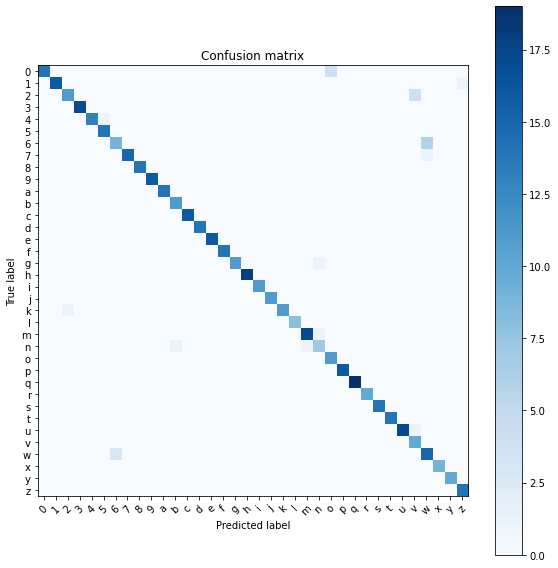

<Figure size 432x288 with 0 Axes>

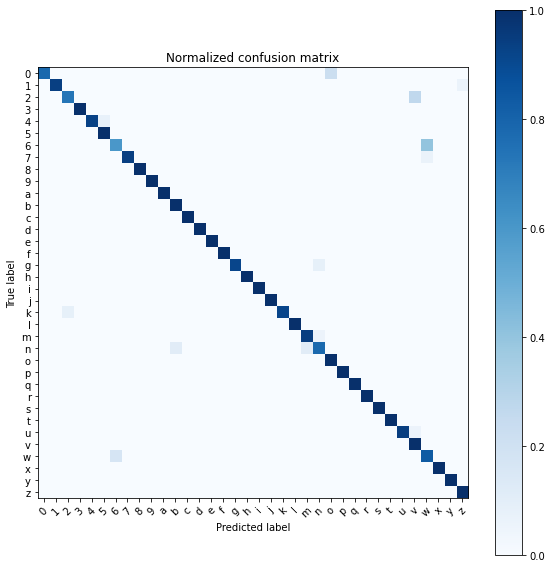

In [11]:
# Confusion matrix and other metrics
# from: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_2_multi_class.ipynb
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
def plot_confusion_matrix(cm, names, title='Confusion matrix', 
                            cmap=plt.cm.Blues):
    ''' Plots a heatmap-like confusion matrix for cm - confusion matrix and 
    names - labels
    '''
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def printScores(model, X, Y):
    ''' Computes the metrics of given model for input X and labels Y and plots 
    the confusion matrix for them
    '''
    # Computing the metrics
    print("Classification report:")
    y_predict = np.argmax(model.predict(X), axis=1)
    print(classification_report(Y, y_predict))
    # Computing confusion matrix
    cm = confusion_matrix(Y, y_predict)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, [chr(i + ord('a')-10) if i>=10 else str(i) for i in range(36)])

    # Normalizing the confusion matrix 
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, 
                          [chr(i + ord('a')-10) if i>=10 else str(i) for i in range(36)], 
                          title='Normalized confusion matrix')

    plt.show()
    
printScores(model, X_test, np.argmax(Y_test, axis=1)) 

ROC AUC score: 0.9749799670129183


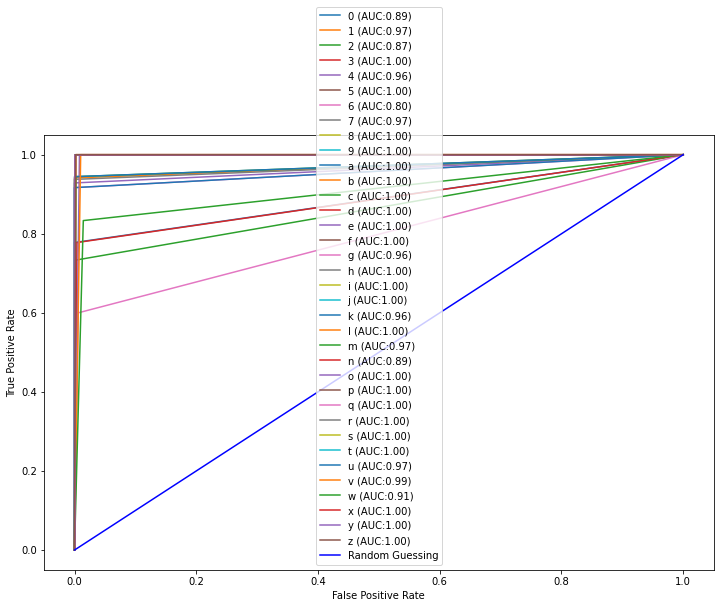

In [12]:
# Roc-auc score
#from: https://stackoverflow.com/questions/66635552/keras-assessing-the-roc-auc-of-multiclass-cnn
target = [chr(i + ord('a')-10) if i>=10 else str(i) for i in range(36)]
Y_pred = model.predict(X_test).argmax(axis=1)

# Plot size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# Scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    '''Plots ROC AUC score for the data 
    y_test - true labels, y_pred - predicted labels
    '''
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(Y_test, Y_pred))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

**Predicting values**

If you want to predict what signs are on your own dataset using the model you can simply change value of *path* to your folder and run the cell below. As output you will get the predicted values.

In [14]:
# If you want to predict your own data you can just apply path to it

path = '/content/archive(3)/asl_dataset/7/'

def decode(pred):
    pred = [chr(i + ord('a')-10) if i>=10 else str(i) for i in pred]
    res = ""
    return res.join(pred)

def pred(path):
    X=[]
    for i in os.listdir(path):
        img = load_img(os.path.join(path, i), color_mode=color, target_size=(height, width))
        X.append(np.array(img)/255)
    X = np.array(X).reshape(-1,width,height,1)
    return decode(model.predict(X).argmax(axis=-1))

print(" Values predicted by model for your images: \n", pred(path))

 Values predicted by model for your images: 
 7777w77777777777777777777777777777777777777777777777777777777777777777


**Conclusions**

The model is working really well. Maybe it should get more data and the data shouldn't be so nice. But right now it's working pretty well and with such clean data we can be sure it recognizes the signs and not some noise in the background.